<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#The data contain five unique years. Later the test data will contain 2010 and 
#the other data will go to training data
house.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010])

In [6]:
house.shape


(1460, 81)

In [7]:
#there are 5types of houses were present
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [8]:
#The non residential houses were removed from the data
house=house[house.MSZoning != 'FV']
house=house[house.MSZoning != 'C (all)']

In [9]:
house.MSZoning.value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [10]:
house.shape #About 75 rows were removed which belong to non-residential type of MSZoning

(1385, 81)

object     43
int64      35
float64     3
dtype: int64


Text(0.5,1,'Data Type Distribution')

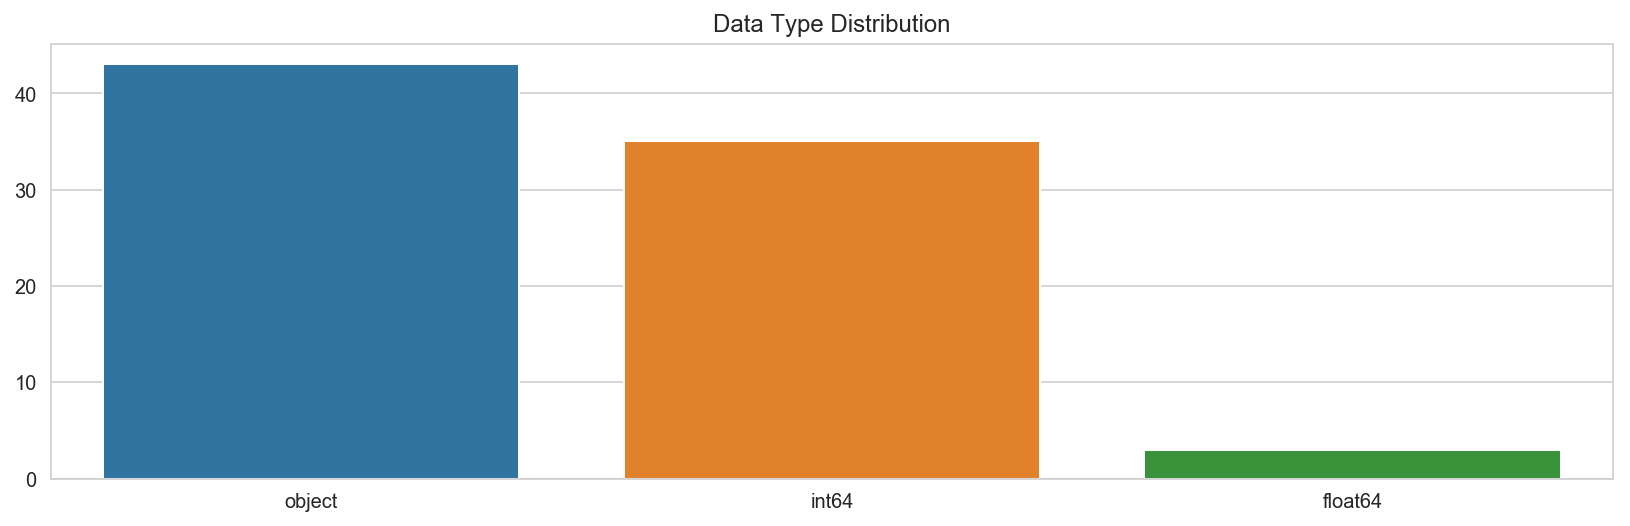

In [11]:
#Datatypes and its distribution

house_types = house.dtypes.value_counts()
print(house_types)

plt.figure(figsize = (14,4))
sns.barplot(x = house_types.index, y = house_types.values)
plt.title("Data Type Distribution")


There are 38 integer and float data type columns which can be used for predicting the target variable and 43 object data type columns which we can use to identify relationship between the feature. However, in order to use these columns for our Machine Learning algorithms we need to Encode them later in our Data Preprocessing stage.

In [12]:
num_col = house.select_dtypes(include=("float64", "int64"))
cat_col = house.select_dtypes(include=("object"))

Checking for the missing values in both categorical and numerical columns of the data

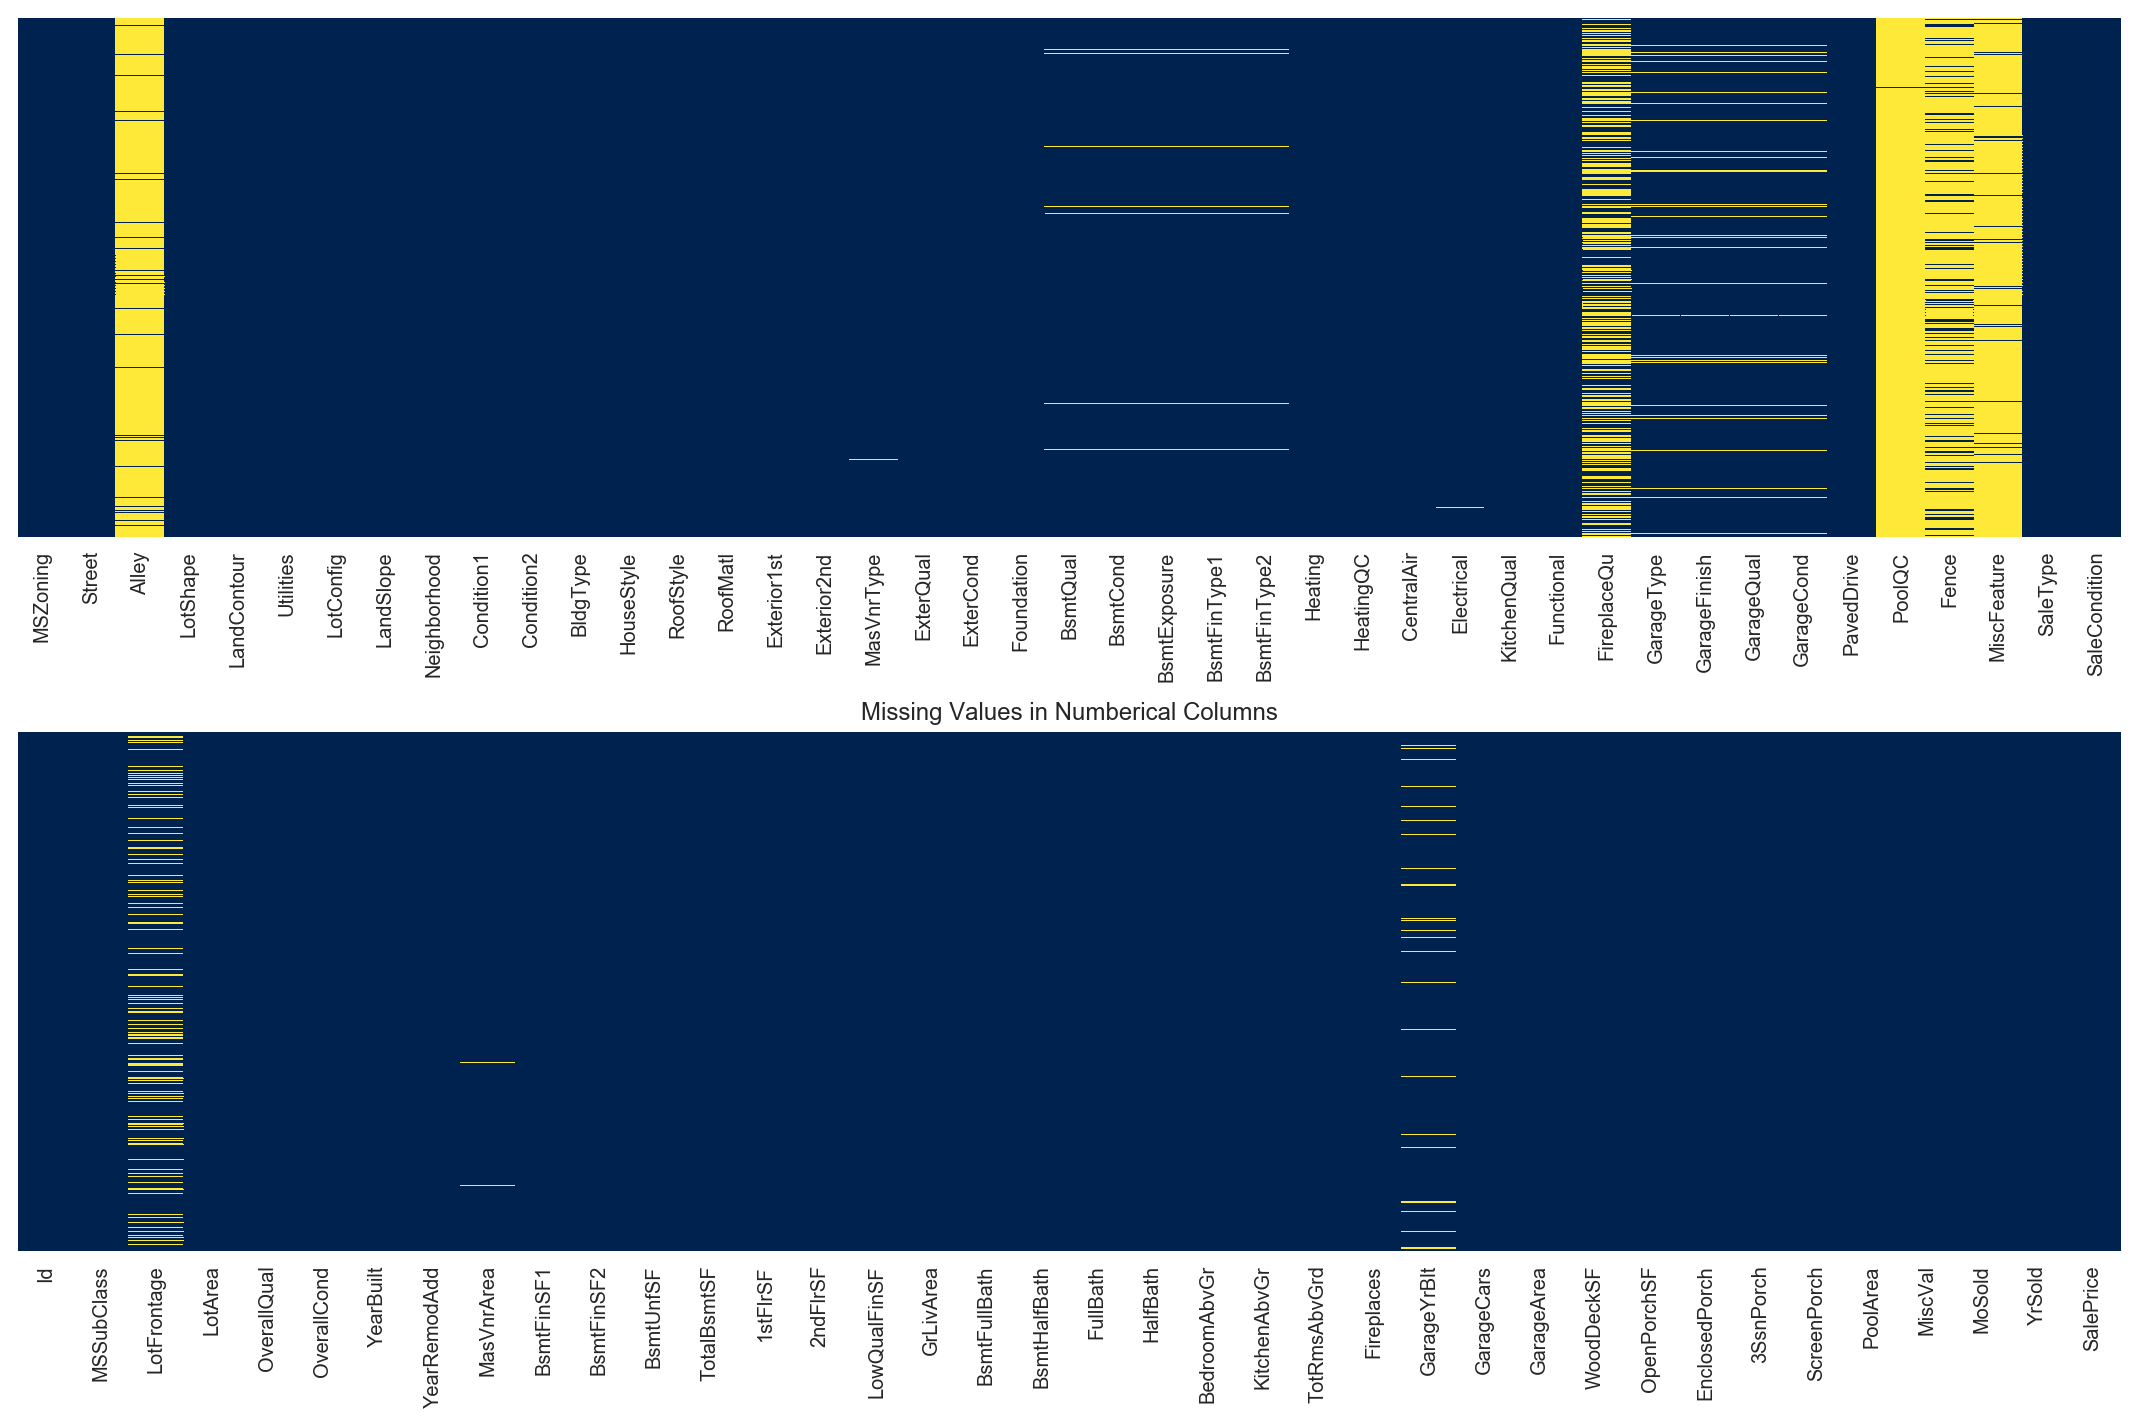

In [13]:
fig, (ax1, ax2) =plt.subplots(nrows=2, ncols=1, figsize = (15,10))

sns.heatmap(cat_col.isnull(), cbar = False, annot = False, cmap ="cividis", yticklabels=False, ax=ax1)
plt.title("Missing Values in Categorical Columns")
sns.heatmap(num_col.isnull(), cbar = False, annot = False, cmap ="cividis", yticklabels=False)
plt.title("Missing Values in Numberical Columns")
plt.tight_layout()

In [14]:
#missing data in Total and percent
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1378,0.994946
MiscFeature,1333,0.962455
Alley,1320,0.953069
Fence,1108,0.800000
FireplaceQu,641,0.462816
LotFrontage,251,0.181227
GarageCond,79,0.057040
GarageType,79,0.057040
GarageYrBlt,79,0.057040
GarageFinish,79,0.057040


In [15]:
#As 'PoolQC', 'MiscFeature', 'Alley' columns have more than 90% missing data. 
#we can drop those columns from our dataframe 
to_drop=['PoolQC', 'MiscFeature', 'Alley']
house.drop(to_drop,axis=1,inplace=True)

### Imputing the missing values

In [16]:
#Fence : data description says NA means "no fence"

house["Fence"] = house["Fence"].fillna("None")

In [17]:
#FireplaceQu : data description says NA means "no fireplace"
house["FireplaceQu"] = house["FireplaceQu"].fillna("None")

In [18]:
#LotFrontage : Since the area of each street connected to the house property most 
#likely have a similar area to other houses in its neighborhood, 
#we can fill in missing values by the median LotFrontage of the neighborhood.

house["LotFrontage"] = house.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [19]:
#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    house[col] = house[col].fillna('None')

In [20]:
#GarageYrBlt, GarageArea and GarageCars : 
#Replacing missing data with 0 (Since No garage = no cars in such garage.)

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    house[col] = house[col].fillna(0)

In [21]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
#missing values are likely zero for having no basement

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    house[col] = house[col].fillna(0)

In [22]:
#replace 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' with none
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    house[col] = house[col].fillna('None')

In [23]:
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. 
#We can fill 0 for the area and None for the type.

house["MasVnrType"] = house["MasVnrType"].fillna("None")
house["MasVnrArea"] = house["MasVnrArea"].fillna(0)

In [24]:
#For Utilities column lets check for the values

house.Utilities.value_counts()

AllPub    1384
NoSeWa       1
Name: Utilities, dtype: int64

In [25]:
#Utilities : For this categorical feature all records are "AllPub", 
#except for one "NoSeWa" 
#this feature won't help in predictive modelling. We can then safely remove it.

house = house.drop(['Utilities'], axis=1)

In [26]:
#For Functional column lets check the values 

house.Functional.value_counts()

Typ     1285
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [27]:
#Since most of the columns are Typ, lets fill the null values with the max values
house["Functional"] = house["Functional"].fillna("Typ")

In [28]:
house.Electrical.value_counts()

SBrkr    1263
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [29]:
#Since most of the columns are SBrkr, lets fill the null values with the max values
house['Electrical'] = house['Electrical'].fillna(house['Electrical'].mode()[0])

In [30]:
#Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. 
#so substitute with the most common string

house['Exterior1st'] = house['Exterior1st'].fillna(house['Exterior1st'].mode()[0])
house['Exterior2nd'] = house['Exterior2nd'].fillna(house['Exterior2nd'].mode()[0])

In [31]:
#for Saletype

house['SaleType'] = house['SaleType'].fillna(house['SaleType'].mode()[0])

In [32]:
#for MSSubClass

house['MSSubClass'] = house['MSSubClass'].fillna("None")

In [33]:
#missing data in Total and percent
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
SalePrice,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0
BsmtQual,0,0.0


In [34]:
#It remains no missing value

In [35]:
house.shape

(1385, 77)

### Let do some analysis about the taget variable SalePrice

In [36]:
house['SalePrice'].describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


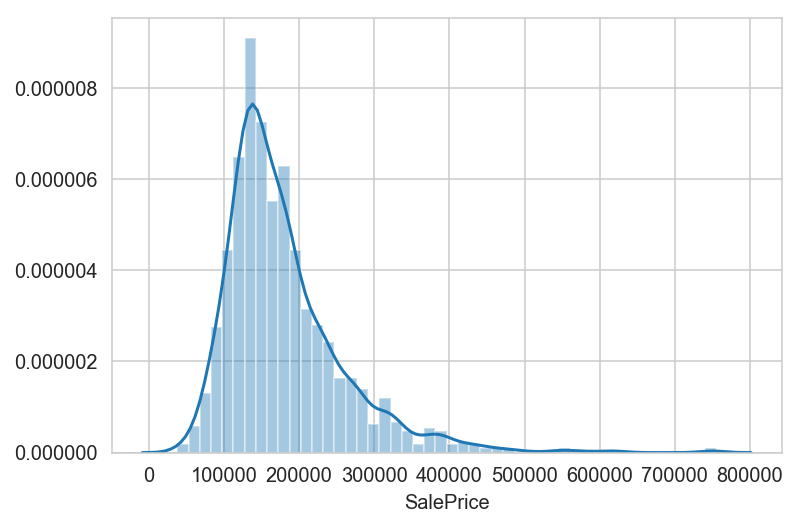

In [37]:
sns.distplot(house['SalePrice']);

In [38]:
#The above graph shows deviation from the normal distribution. It has positive skewness and show peakedness.

In [39]:
#skewness and kurtosis
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.961336
Kurtosis: 6.793400


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


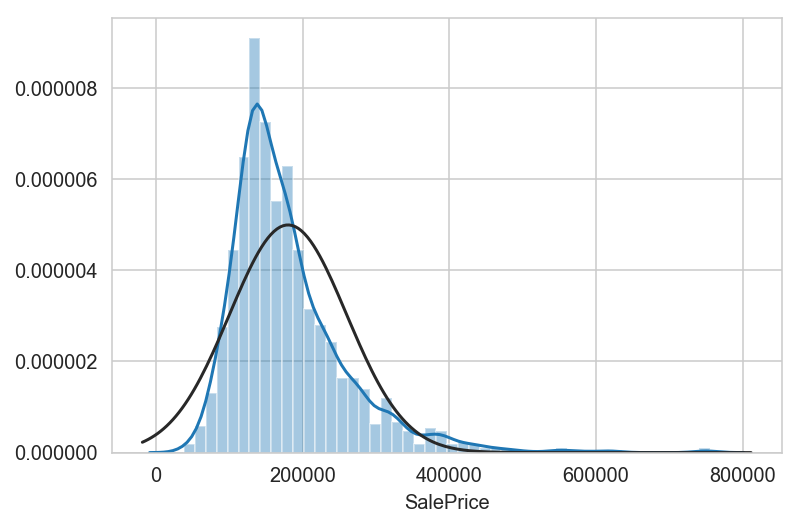

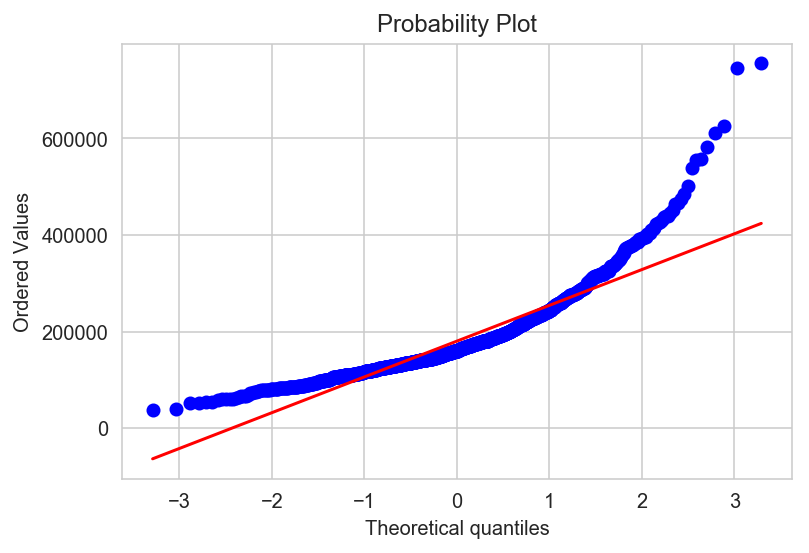

In [40]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(house['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)


In [41]:
#The target variable is right skewed. Since the skewness is not very significant, 
#SalePrice data was used as such without any transformation.


## Feature Engineering

1. The TotalBSmtSF is eqaual to sum of ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'). And therefore only TotalBSmtSF was used for analysis.

2. The GrLivArea is equal to sum of ('1stFlrSF', '2ndFlrSF','LowQualFinSF'). And therefore only GrLivArea is used for analysis.

3. For Garage size, I am using GarageArea and dropping the GarageCars(Size of garage in car capacity)

4. Also dropping Id column which doesnot have influence on target value

5. Creating another column totalSF by adding TotalBsmtSF and GrLivArea

In [42]:
house['TotalSF']=house.TotalBsmtSF+house.GrLivArea

to_drop=['Id','GrLivArea', 'TotalBsmtSF','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GarageCars']
   
house.drop(to_drop, inplace=True, axis=1)


In [43]:
#  I am summing up the number of both full and half bathrooms 
#at basement and above ground to one term bath

house['Bath']=house.BsmtFullBath+house.BsmtHalfBath+house.FullBath+house.HalfBath


In [44]:
to_drop=['BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath']
house.drop(to_drop, inplace=True, axis=1)


In [45]:
# I am creating a new column which is outdoorSF by summing up 'WoodDeckSF', 'OpenPorchSF',
#'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'

house['OutdoorSF']=house.WoodDeckSF+house.OpenPorchSF+house.EnclosedPorch+house['3SsnPorch']+house.ScreenPorch+house.PoolArea

In [46]:
to_drop=['WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
house.drop(to_drop, inplace=True, axis=1)

In [47]:
house.shape

(1385, 60)

In [48]:
house.shape

(1385, 60)

### The features are classified as fixed and renewable features

In [49]:
fixed_features=['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'YearBuilt','Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageType', 'GarageYrBlt', 'PavedDrive', 'Fence', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
       'TotalSF', 'Bath', 'OutdoorSF']
      

In [50]:
renewable_features=['OverallQual', 'OverallCond','YearRemodAdd','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'ExterQual', 'ExterCond','Heating','HeatingQC', 'CentralAir', 'Electrical', 
                    'KitchenQual','FireplaceQu','GarageQual','GarageFinish', 'GarageCond','Fence', 'MiscVal']

In [51]:
house.shape

(1385, 60)

## Model fitting and evaluation using fixed features

In [52]:
X=house[fixed_features]
X.shape

(1385, 39)

#### Getting dummy variables for the categorical columns

In [53]:
cols=['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle','Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageType','PavedDrive', 'Fence', 
       'SaleType', 'SaleCondition']

In [54]:

X_d= pd.get_dummies(X,columns=cols,drop_first=True)
print(X_d.shape)

(1385, 154)


#### Train test split based on the year sold

In [55]:
#Train data with data from yrSold 2006,2007 and 2008. Test data is with data from YrSold 2010

year_column = 'YrSold'


X_train=X_d[X_d[year_column].isin([2008, 2006, 2007])]
X_test=X_d[X_d[year_column] == 2010]

y_train=house['SalePrice'][house[year_column].isin([2008, 2006, 2007])]
y_test=house['SalePrice'][house[year_column] == 2010]


In [56]:
X_train.shape

(900, 154)

In [57]:
col_lasso=X_train.columns

In [58]:
y_train.shape

(900,)

In [59]:
X_test.shape

(164, 154)

In [60]:
y_test.shape

(164,)

In [61]:
from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test=ss.transform(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [62]:
Xs_train.shape

(900, 154)

In [63]:
y_train.shape

(900,)

## Model Selection

#### LinearRegression, Ridge and lassso models were evaluated to choose the best fit model

### 1. LinearRegression

In [64]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs_train, y_train, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[-1.71116896e+25  8.24384673e-01 -4.52007759e+17 -1.53086845e+20
 -1.25459204e+22  5.84835858e-01 -4.65433837e+22  7.50234038e-01
 -8.81918322e+23  7.51173355e-01]
-1.805285073787334e+24


In [65]:
# The mean R^2 is extremely negative. All of the R^2 scores are negative in cross-validation.
# The linear regression is performing far worse than the baseline on the testing sets.
# It's probably dramatically overfitting, and the redundant variables are affecting
# the coefficients in unusual ways.

### 2. Ridge Regression

In [66]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print(optimal_ridge.alpha_)

390.6939937054621


In [67]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.88280735 0.81833077 0.88386726 0.71934844 0.75919958 0.78389229
 0.85180149 0.76938618 0.50845434 0.82729794]
0.7804385636622888


In [68]:
# It's better than the linear regression. 
# There's likely so much multicollinearity in the data that linear regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

### 3. Lasso Regression
####  An optimal value for lasso regression alpha using LassoCV

In [69]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

769.4523669759267


................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


#### Cross-validate the lasso  R2  with the optimal alpha

In [70]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.88885336 0.84439945 0.90274286 0.71022351 0.80259007 0.62185623
 0.87718525 0.75868041 0.35887802 0.81823013]
0.7583639299921223


In [71]:
model_lasso=lasso.fit(Xs_train, y_train)

In [72]:
# Similar to ridge, Lasso model also preforms better than linearregression model. 
# Since there is not much significant difference between ridge and Lasso,
# I have chosen lasso model for further calculations of predictions and residuals. 

### coefficients for variables in the lasso

In [73]:
lasso_coefs = pd.DataFrame({'variable':col_lasso,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
12,TotalSF,25530.924841,25530.924841
58,Neighborhood_NoRidge,11434.432879,11434.432879
100,BsmtQual_Gd,-11266.576934,11266.576934
59,Neighborhood_NridgHt,11246.823157,11246.823157
102,BsmtQual_TA,-10311.739693,10311.739693
13,Bath,7703.484771,7703.484771
65,Neighborhood_StoneBr,7478.678453,7478.678453
11,GarageArea,7006.354571,7006.354571
9,TotRmsAbvGrd,6807.829126,6807.829126
10,Fireplaces,6258.269984,6258.269984


In [74]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Percent variables zeroed out: 0.4935064935064935


In [75]:
model_lasso=lasso.fit(Xs_train, y_train)

#calculating the predicted value

predictions_mod1=model_lasso.predict(Xs_test)

In [76]:
#residual calculation
Residuals_mod1=y_test-predictions_mod1

In [77]:
X_test['Residuals']=Residuals_mod1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
X_test['predictions']=predictions_mod1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
X_test['y_test']=y_test

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
X_test.head()

,YearBuilt,GarageYrBlt,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,TotalSF,Bath,OutdoorSF,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Residuals,predictions,y_test
16,1970,1970.0,3,2010,73.0,11241,180.0,2,1,5,1,480,2008,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,-2324.325766,151324.325766,149000
24,1968,1968.0,5,2010,71.0,8246,0.0,3,1,6,1,270,2120,2,496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-883.613460,154883.613460,154000
26,1951,2005.0,5,2010,60.0,7200,0.0,3,1,5,0,576,1800,2,254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,3714.743229,131085.256771,134800
27,2007,2008.0,5,2010,98.0,11478,200.0,3,1,7,1,772,3408,3,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,2984.583885,303015.416115,306000
33,1959,1959.0,4,2010,70.0,10552,0.0,4,1,6,1,447,309

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


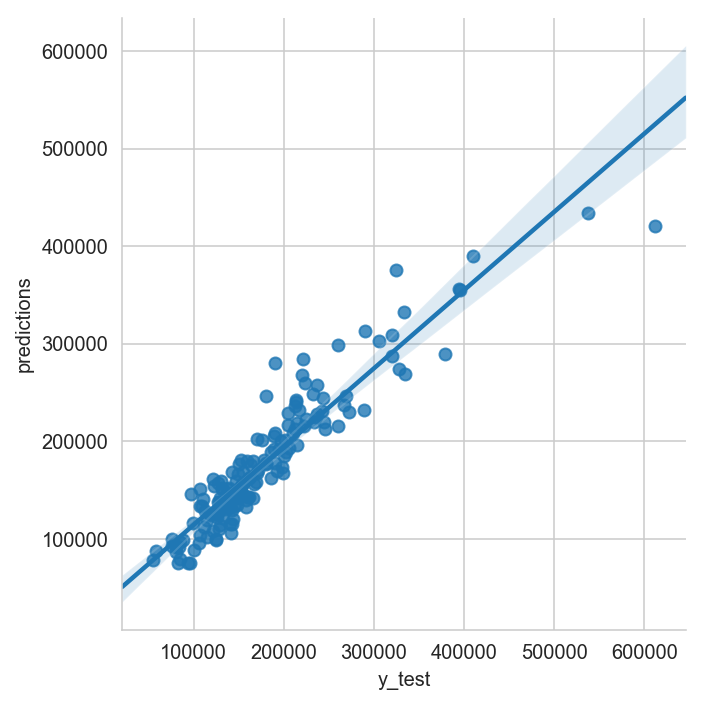

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.lmplot(x='y_test', y='predictions', data=X_test)

In [82]:
#the actual and predicted values has linear relationship. it shows that our model well fitted. 

#### Residual analysis

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


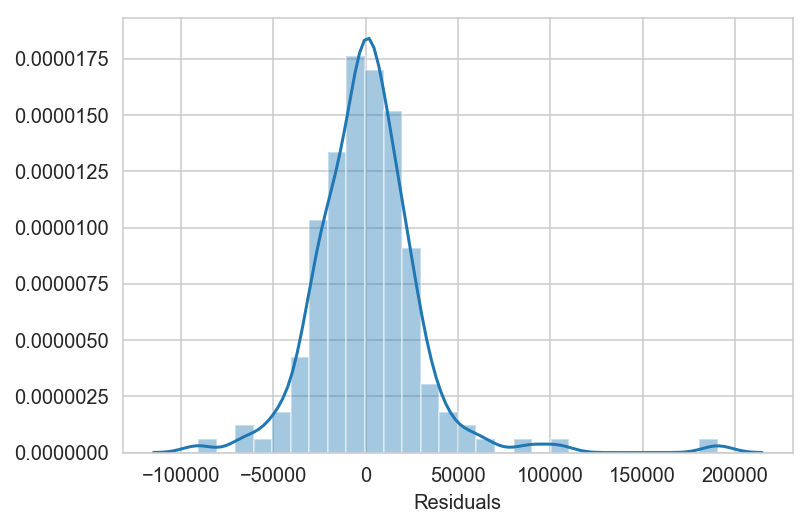

In [83]:

sns.distplot(X_test['Residuals'])

# The errors are more or less skewed to the right, but do show approximate normality otherwise.

### Summary of results (Question 1):
1. The data were cleaned and feature engineering was done. 
2. The features were seperated as fixed and renewable columns. And the model was evaluated using only fixed features. 
3. Both Ridge and Lasso models preformed better, when compared to LinearRegression model. 
4. Lasso model was used for further analysis
5. Based on the model R2 value of 0.758, we can say that the predictor varaiables chosen for the model could explain 75.8% of variance in the target variable.
6. The TotalSF(which is the combination of ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GrLivArea') is the most feature that could contribute to the SalePrice. For 1 unit increase in TotalSF the SalePrice could increase by 25,530
7. The second important feature id the Neighborhood_NoRidge and Nridght, which corresponds to the houses located in Northridge and Northridge Heights. When the house is located in that area then it could increase the SalePrice by 11434. Also, the houses present at Stone Brook and  Crawler could increase the SalPrice by 7500 and 4900 respectively.
8. The next factor is the number of Bath rooms which is obtained by summing up the number of both full and half bathrooms. For every increase in the Bath there is increase of SalePrice by 7703. 
9. Then, Total number of rooms above ground, Garage Area, Fireplaces and YearBuilt have positive effect on the SalePrice. 
10. The Basement Quality which corresponds to the height of the basement is the most important factor which accounts for the depreciation in the house price. The BaseQuality which is Good and Typical shows depreciation of SalePrice about 10,000 to 11,000.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### As the renewable features has categorical variable. The model was fitted with the whole data set to understand the effect of renewable features

In [84]:
house.shape

(1385, 60)

In [85]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,Bath,OutdoorSF
0,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,548,TA,TA,Y,None,0,2,2008,WD,Normal,208500,2566,4,61
1,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,460,TA,TA,Y,None,0,5,2007,WD,Normal,181500,2524,3,298
2,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,608,TA,TA,Y,None,0,9,2008,WD,Normal,223500,2706,4,42
3,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,642,TA,TA,Y,None,0,2,2006,WD,Abnorml,140000,2473,2,307
4,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,836,TA,TA,Y,None,0,12,2008,WD,Normal,250000,3343,4,276


In [86]:
dummy_cols=['MSSubClass', 'MSZoning','Street','LotShape','LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle','Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageType','PavedDrive', 'Fence', 
       'SaleType', 'SaleCondition','OverallQual', 'OverallCond','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond','Heating','HeatingQC', 'CentralAir', 'Electrical', 
       'KitchenQual','FireplaceQu','GarageQual','GarageFinish', 'GarageCond','Fence']

In [87]:
house_dummy= pd.get_dummies(house,columns=dummy_cols,drop_first=True)
print(house_dummy.shape)

(1385, 264)


In [88]:
house_dummy.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,MiscVal,MoSold,YrSold,SalePrice,TotalSF,Bath,OutdoorSF,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_

In [89]:
house_dummy.drop('SalePrice', axis=1, inplace=True)

In [90]:
X_full=house_dummy

In [91]:
y_full=house['SalePrice']

In [92]:
#Train data with data from yrSold 2006,2007 and 2008. Test data is with data from YrSold 2010

year_column = 'YrSold'



X_train_2=X_full[X_full[year_column].isin([2008, 2006, 2007])]
X_test_2=X_full[X_full[year_column] == 2010]

y_train_2=house['SalePrice'][house[year_column].isin([2008, 2006, 2007])]
y_test_2=house['SalePrice'][house[year_column] == 2010]

In [93]:
X_train_2.shape

(900, 263)

In [94]:
X_test_2.shape

(164, 263)

In [95]:
y_train_2.shape

(900,)

In [96]:
y_test_2.shape

(164,)

In [97]:
col2_lasso=X_train_2.columns

### Fitting the model

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score


ss = StandardScaler()
Xs_train_2 = ss.fit_transform(X_train_2)
Xs_test_2=ss.transform(X_test_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [99]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train_2, y_train_2)

print(optimal_ridge.alpha_)

390.6939937054621


In [100]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train_2, y_train_2)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1495.4052267625718


.......................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [101]:
def print_cross_val_results(model,name,X,y,folds=5):
    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)
    scores = cross_val_score(model, X, y, cv=folds)
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

OLS = LinearRegression()
ridge = Ridge(alpha=optimal_ridge.alpha_)
lasso= Lasso(alpha=optimal_lasso.alpha_)

print_cross_val_results(OLS,"Linear Regression",Xs_train_2,y_train_2)
print_cross_val_results(ridge,"Ridge Regression",Xs_train_2,y_train_2)
print_cross_val_results(lasso,"Lasso Regression",Xs_train_2,y_train_2)

------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression
Cross-validated scores: [-1.80040197e+22 -8.65866590e+21 -1.21663091e+24 -3.52507672e+23
 -3.12898385e+21]
Mean CV R2: -3.1978605056877747e+23
Std CV R2: 4.676635009784824e+23
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression
Cross-validated scores: [0.90996562 0.82483356 0.82490288 0.83912052 0.6700648 ]
Mean CV R2: 0.813777478211534
Std CV R2: 0.07847773374755958
------------------------------------

5-Fold Cross Validated Results for Model: Lasso Regression
Cross-validated scores: [0.89790504 0.81651089 0.82274368 0.83873023 0.58449838]
Mean CV R2: 0.7920776446019643
Std CV R2: 0.1077055627222563


* Similary to the model 1 which is developed previously, ridge and lasso model preform better than the LinearRegression model. As there is no significant difference between the ridge and lasso model. I used lasso model for further analysis.

* The model 2 which is developed with full dataset performed better than model 1. 

### Coefficient from lasso model

In [102]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train_2, y_train_2, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.89176895 0.91270328 0.92667817 0.70847831 0.83252136 0.75254513
 0.92159862 0.79827175 0.42283555 0.84439234]
0.8011793435770007


In [103]:
model2_lasso=lasso.fit(Xs_train_2, y_train_2)

In [104]:
lasso_coefs_ = pd.DataFrame({'variable':col2_lasso,
                            'coef':(lasso.coef_),
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs_.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs_.head(20)

,variable,coef,abs_coef
14,TotalSF,16185.619219,16185.619219
164,OverallQual_10,12251.864596,12251.864596
163,OverallQual_9,10543.816623,10543.816623
162,OverallQual_8,9076.594986,9076.594986
15,Bath,8276.523174,8276.523174
60,Neighborhood_NoRidge,7400.612585,7400.612585
10,GarageArea,7049.954752,7049.954752
61,Neighborhood_NridgHt,6674.337519,6674.337519
81,Condition2_PosN,-6411.984904,6411.984904
7,TotRmsAbvGrd,6357.194411,6357.194411


In [105]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Percent variables zeroed out: 0.7224334600760456


In [106]:
predictions_mod2=model2_lasso.predict(Xs_test_2)

In [107]:
Residuals_mod2=y_test_2-predictions_mod2

In [108]:
X_test_2['predictions_mod2']=predictions_mod2
X_test_2['Residuals_mod2']=Residuals_mod2
X_test_2['y_test_2']=y_test_2


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [109]:
X_test_2.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,MiscVal,MoSold,YrSold,TotalSF,Bath,OutdoorSF,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageF

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


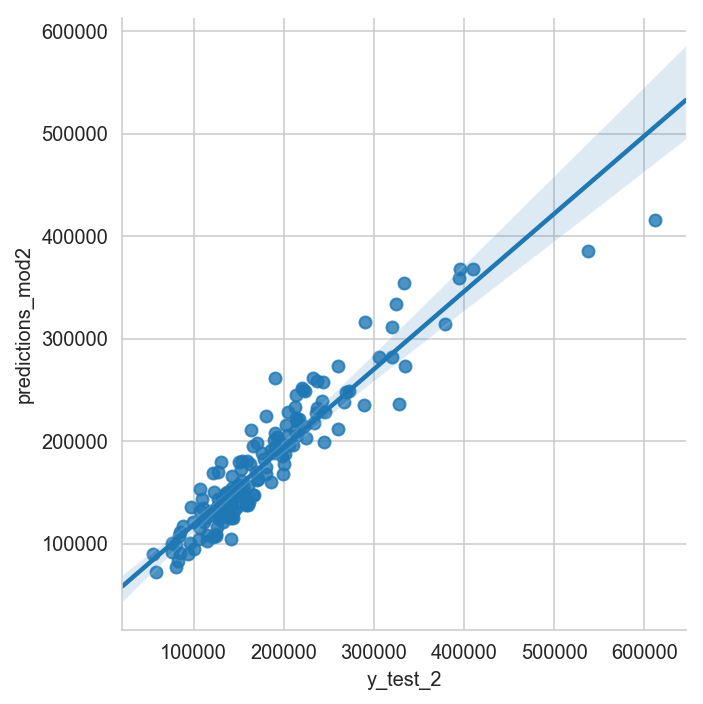

In [110]:
sns.lmplot(x='y_test_2', y='predictions_mod2', data=X_test_2) #there is linear relationship between test and predicted data.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


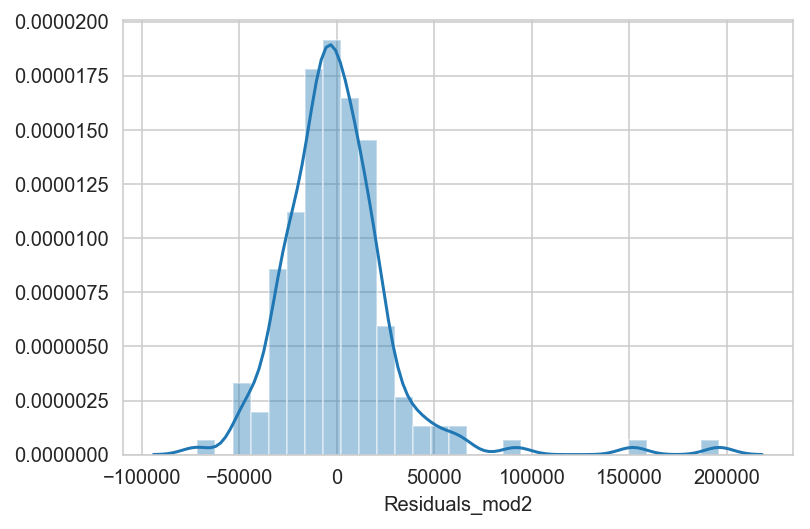

In [111]:
sns.distplot(X_test_2['Residuals_mod2']) # the residuals shows slight right skew.

### Summary of results (Question 2):

1. The model was evaluated using entire data set. 
2. Both Ridge and Lasso models preformed better, when compared to LinearRegression model. 
3. Lasso model was used for further analysis
4. Based on the model R2 value of 0.80, we can say that the predictor varaiables chosen for the model could explain 80% of variance in the target variable.
5. The TotalSF(which is the combination of ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GrLivArea') is the most feature that could contribute to the SalePrice. For 1 unit increase in TotalSF the SalePrice could increase by 16,185.
6. The OverallQual which relates the overall material and finish of house could contribute most to the SalePrice. For every increase in overall quality there is about 9000 to 12000 increase in SalePrice. If the overall quality of the house increases the SalePrice also increases.
7. The second important feature is the Roof Material which is Wood Shingles. For very unit increase in this could increase the SalePrice by 6000.
8. The Year Remodel and the Quality of the materials on the exterior of the house also contributes to the SalePrice. 
9. From the model 2, we can conclude that the renovable features are also important features which could influence the SalePrice. The most important renevable features that could influence the SalePrice are overall quality of house, Roof material, year remodel and quality of materials in the exterior of the house. 



<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

#### There are five different SaleConditions and only Normal and Abnormal was taken for further evaluation

In [112]:
house['SaleCondition'].value_counts()

Normal     1155
Partial     103
Abnorml      92
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [113]:
#Only the normal and abnormal SaleCondition were kept and the other types of SaleConditions were removed from the data
house=house[house.SaleCondition != 'Partial']
house=house[house.SaleCondition != 'Family']
house=house[house.SaleCondition != 'Alloca']
house=house[house.SaleCondition != 'AdjLand']

In [114]:
house['SaleCondition'].value_counts() # only two SaleCondition

Normal     1155
Abnorml      92
Name: SaleCondition, dtype: int64

In [115]:
SaleCondition_count = house.SaleCondition.value_counts()

SaleCondition_count

Normal     1155
Abnorml      92
Name: SaleCondition, dtype: int64

Class 0: 1155
Class 1: 92
Proportion: 12.55 : 1


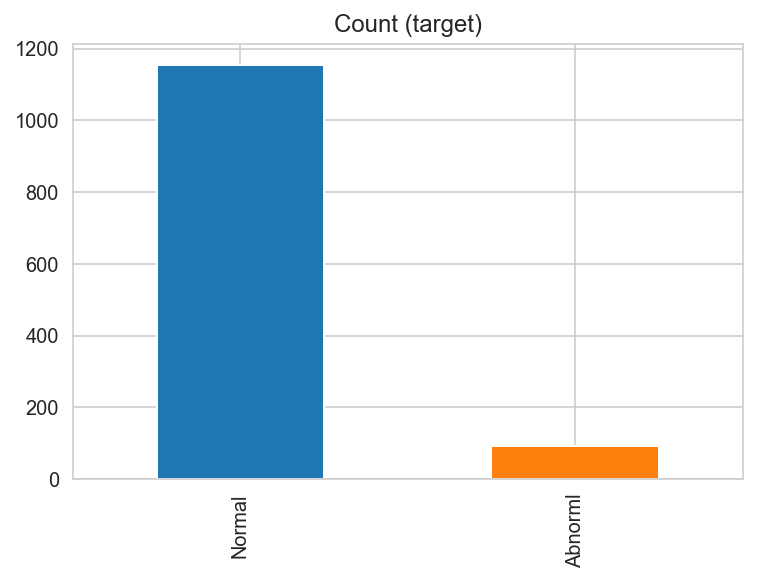

In [116]:
import numpy as np
import pandas as pd

target_count = house.SaleCondition.value_counts()

target_count
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [117]:
# Create a boolean column to show whether or not a sale was abnormal
house['SaleCondition'] = house['SaleCondition'].map(lambda x: 0 if x =="Normal" else 1)




In [118]:
house.shape

(1247, 60)

In [119]:
dummy_cols=['MSSubClass', 'MSZoning','Street','LotShape','LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle','Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional',
       'GarageType','PavedDrive', 'Fence', 
       'SaleType', 'OverallQual', 'OverallCond','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond','Heating','HeatingQC', 'CentralAir', 'Electrical', 
       'KitchenQual','FireplaceQu','GarageQual','GarageFinish', 'GarageCond','Fence']

In [120]:
house_dummy= pd.get_dummies(house,columns=dummy_cols,drop_first=True)
print(house_dummy.shape)

(1247, 256)


In [121]:
house_dummy.drop('SaleCondition', axis=1, inplace=True)

### Train Test Split

In [122]:
from sklearn.model_selection import train_test_split


X = house_dummy
y = house['SaleCondition']




X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 1)

In [123]:
X_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,MiscVal,MoSold,YrSold,SalePrice,TotalSF,Bath,OutdoorSF,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None

In [124]:
X_train.shape

(872, 255)

In [125]:
X_test.shape

(375, 255)

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,accuracy_score
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(recall_score(y_test,y_pred,average=None))


[1. 0.]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [127]:
print(accuracy_score(y_test,y_pred))

0.9013333333333333


In [128]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix_value = confusion_matrix(y_test,y_pred)

In [129]:
sns.set(font_scale=1.4)
confusion_matrix_value
#sns.heatmap(confusion_matrix_value, annot=True)

array([[338,   0],
       [ 37,   0]])

In [130]:

report=classification_report(y_test,y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       338
           1       0.00      0.00      0.00        37

   micro avg       0.90      0.90      0.90       375
   macro avg       0.45      0.50      0.47       375
weighted avg       0.81      0.90      0.85       375



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### From the classification report:
 * Precision on majority class is 90% and the recall on minority class is 0% which is very poor value. 
 * Here, I am using two methods to address the class imbalance.
 * 1. Using resampling dataset: Random undersampling
 * 2. Logistic Regression with balanced class weights
    

## 1. Resampling Dataset: Random UnderSampling

In [131]:
df=pd.get_dummies(house,columns=dummy_cols,drop_first=True)

In [132]:
# Undersample the data

Abnormal_no = len(df[df['SaleCondition'] == 1])
Normal_indices = df[df.SaleCondition == 0].index
random_indices = np.random.choice(Normal_indices,Abnormal_no, replace=False)
Abnormal_indices = df[df.SaleCondition == 1].index
under_sample_indices = np.concatenate([Abnormal_indices,random_indices])
under_sample = df.loc[under_sample_indices]

In [133]:
Abnormal_no

92

In [134]:
Normal_indices

Int64Index([   0,    1,    2,    4,    5,    6,    7,    9,   10,   12,
            ...
            1446, 1447, 1448, 1450, 1452, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', length=1155)

In [135]:
under_sample['SaleCondition'].value_counts()

1    92
0    92
Name: SaleCondition, dtype: int64

In [136]:
under_sample.shape

(184, 256)

In [137]:
X_under = under_sample.loc[:,under_sample.columns != 'SaleCondition']
y_under = under_sample.loc[:,under_sample.columns == 'SaleCondition']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.7, random_state = 0)





In [138]:
lr_under = LogisticRegression()
lr_under.fit(X_under_train,y_under_train)
y_under_pred = lr_under.predict(X_under_test)
print(recall_score(y_under_test,y_under_pred))
print(accuracy_score(y_under_test,y_under_pred))

0.6825396825396826
0.6511627906976745


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [139]:
confusion_matrix_value = confusion_matrix(y_under_test,y_under_pred)

In [140]:
sns.set(font_scale=1.4)
confusion_matrix_value
#sns.heatmap(confusion_matrix_value, annot=True)

array([[41, 25],
       [20, 43]])

In [141]:
from sklearn.metrics import confusion_matrix,classification_report
report=classification_report(y_under_test,y_under_pred)

print(report)

              precision    recall  f1-score   support

           0       0.67      0.62      0.65        66
           1       0.63      0.68      0.66        63

   micro avg       0.65      0.65      0.65       129
   macro avg       0.65      0.65      0.65       129
weighted avg       0.65      0.65      0.65       129



####  From Resampling classification report
* By undersampling the dataset, the precision on the majority class decreased(90% to 62%) while significantly increasing the recall on minority samples(0% to 68%)



### 2. Logistic Regression with balanced class weights

* The weights which is inversely proportional to the size of the class variable will be attached


In [142]:
lr_balanced = LogisticRegression(class_weight = 'balanced')
lr_balanced.fit(X_train,y_train)
y_balanced_pred = lr_balanced.predict(X_test)
print(recall_score(y_test,y_balanced_pred))


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2972972972972973


In [143]:
print(accuracy_score(y_test,y_balanced_pred))

0.808


In [144]:
from sklearn.metrics import confusion_matrix
confusion_matrix_value = confusion_matrix(y_test,y_balanced_pred)

In [145]:
sns.set(font_scale=1.4)
confusion_matrix_value
#sns.heatmap(confusion_matrix_value, annot=True)

array([[292,  46],
       [ 26,  11]])

In [146]:
report=classification_report(y_test,y_balanced_pred)

print(report)


              precision    recall  f1-score   support

           0       0.92      0.86      0.89       338
           1       0.19      0.30      0.23        37

   micro avg       0.81      0.81      0.81       375
   macro avg       0.56      0.58      0.56       375
weighted avg       0.85      0.81      0.83       375



####  From Logistic Regression Classification report
* When compared to undersampling the dataset, the precision on the majority class increased (62% to 92%). However, the recall on minority samples significantly decreased (68% to 30%)

#### Tried doing Logistic Regression using another method

In [147]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold



clf_base=LogisticRegression()

grid={'C':np.logspace(-5,0,100),
     'penalty':['l1','l2'],
     'class_weight':['balanced']}

cv=KFold(n_splits=5,shuffle=True,random_state=0)
clf=GridSearchCV(clf_base,grid,cv=cv,n_jobs=8,scoring='f1_macro')
clf.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00]), 'penalty': ['l1', 'l2'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [148]:
# best parameters on the training data:
clf.best_params_

{'C': 0.5590810182512223, 'class_weight': 'balanced', 'penalty': 'l1'}

In [149]:
#l1 lasso analysis was chosen

In [150]:
# assign the best estimator to a variable:
best_lr = clf.best_estimator_

best_lr

LogisticRegression(C=0.5590810182512223, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [151]:
# Score it on the testing data:
best_lr.score(X_test, y_test)

0.808

In [152]:
coef=clf.best_estimator_.coef_
intercept=clf.best_estimator_.intercept_

In [153]:
intercept

array([0.])

In [154]:
coef

array([[-2.18028240e-03,  1.90926494e-05,  1.36849114e-03,
        -6.17348854e-03,  3.64198995e-03,  0.00000000e+00,
        -2.99959452e-01,  2.46174225e-01, -1.13065628e+00,
        -9.43979091e-04, -6.38276876e-04, -1.85518245e-02,
        -3.03628749e-02,  6.64948447e-03, -4.22081901e-05,
         9.83280365e-04,  7.55751352e-02,  3.55477752e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.52554938e-01,
         0.00000000e+00,  1.43492588e+00,  0.00000000e+00,
        -3.94249257e-01,  0.00000000e+00, -2.08518743e+00,
         0.00000000e+00,  0.00000000e+00, -6.42184318e-01,
        -1.29870509e+00,  0.00000000e+00,  2.75503625e-01,
         0.00000000e+00, -1.36616944e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.79676035e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [155]:
report=classification_report(y_test,clf.predict(X_test))

In [156]:
print(report)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       338
           1       0.20      0.32      0.25        37

   micro avg       0.81      0.81      0.81       375
   macro avg       0.56      0.59      0.57       375
weighted avg       0.85      0.81      0.83       375



#### Conclusions:

* Both the random undersampling and Logistic Regression with balanced class weights didnot show optimum results. 
* therefore, further evaluations need to be done on the other methods such as Random over-sampling, Python imbalanced-learn module, Random under-sampling and over-sampling with imbalanced-learn. 